# Notebook for checking how we are doing with MUA

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random
import scipy

%matplotlib inline

# Get data

In [2]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [3]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [4]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Get single-reach trials

In [5]:
control_idxs = np.where(data["pattern_id"] == 0)[0]
control_idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449])

In [6]:
stim_idxs = np.where(data["pattern_id"][:150] > 2)[0]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
control_idxs = np.sort(np.concatenate((control_idxs, stim_idxs)))

In [7]:
# get no laser trials
control_idxs = np.intersect1d(control_idxs, np.where(data["single"] == 1)[1])

In [8]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        17,  19,  20,  21,  23,  24,  30,  33,  36,  39,  40,  43,  44,
        45,  46,  49,  50,  51,  53,  54,  60,  61,  62,  63,  67,  69,
        70,  71,  74,  77,  81,  82,  88,  89,  91, 105, 107, 116, 117,
       137, 139, 145, 148])

In [9]:
np.unique(data["pattern_id"][control_idxs])

array([ 0, 14, 17, 20], dtype=uint8)

## Get relevant time information

In [10]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[  14310.86566601,   31635.98602851,   66118.75767016,
          83391.57934485,  100671.38676484,  117878.88228075,
         135202.39780987,  152469.08335693,  169748.98517889,
         187076.46559048,  221580.66647786,  256113.84876805,
         343834.9853677 ,  378401.3027471 ,  412964.5048617 ,
         430223.16624186,  447413.10299254,  481960.06796941,
         499231.75682054,  603021.71245162,  654737.65694326,
         706335.69338242,  758001.60483338,  775155.48003398,
         826860.47389786,  844093.36354196,  861313.50892099,
         878540.9232512 ,  930339.75266686,  947557.06598697,
         964758.89738507,  999343.5287454 , 1016540.9232512 ,
        1120486.35891627, 1137781.83706221, 1155099.87727745,
        1172344.18955914, 1241575.09676201, 1276101.01010101,
        1293329.17964694, 1310604.83338053, 1362412.63098272,
        1414270.55602757, 1483298.49900878, 1500421.5047673 ,
        1604049.56103087, 1621268.29038044, 1655724.06306051,
        

In [11]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[310., 280., 330., 320., 300., 250., 270.,  90., 260., 260., 230.,
        230., 310., 290., 200., 280., 220., 270., 270., 300., 230., 290.,
        290., 310., 270., 320., 280., 290., 250., 270., 250., 280., 270.,
        290., 270., 270., 270., 260., 300., 320., 310., 310., 280., 280.,
        340., 270., 300., 310., 300., 300., 290., 200., 290., 340., 250.,
        220.]])

In [12]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[540., 540., 560., 570., 520., 540., 600., 460., 510., 490., 500.,
        530., 510., 520., 510., 630., 510., 480., 520., 570., 490., 670.,
        590., 570., 510., 640., 520., 560., 480., 520., 530., 490., 590.,
        520., 550., 570., 620., 520., 510., 550., 580., 650., 510., 520.,
        570., 480., 570., 550., 570., 530., 500., 560., 530., 570., 590.,
        480.]])

## Get the AP.bin file

In [13]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [14]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [15]:
meta_data = get_meta(meta_path)

In [16]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [17]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [18]:
vmax

0.6

In [19]:
imax

512.0

In [20]:
gain

500.0

# Get trials

In [21]:
def get_trials(idxs):
    
    filtered_datas = list()
    medians = list()
    
    for i in tqdm(idxs):
        trial_no = i
        # get time points in ap space
        lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
        
        # get end of behavior = mouth (260ms) + 300ms 
        end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)

    
        trial = ap_data[:150, lift_time:end_behavior]
    
        conv_data = 1e6 * trial / vmax / imax / gain
    
        filt_data = butter_filter(conv_data, 1_000, 30_000)

        filtered_datas.append(filt_data)
    
        c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
        m_start = c_start - (30 * 2000)
        trial_median = ap_data[:150, m_start:c_start]
    
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        median = np.median(trial_median, axis=1)
        medians.append(median)
    
       # spike_ixs, counts = get_spike_events(filt_data, median)
        
        # a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        # for i, sc in enumerate(spike_ixs):
        #     a[i, sc] = 1
    
        # b = bin_size * 30 # 30ms per bin
        # binned_spikes = bin_spikes(a, b)
    
        # lift_start = int(50 / bin_size)

        # lift = int(data["lift_ms"][0, trial_no] / bin_size) 
        # # grab duration
        # grab = int(data["grab_ms"][0, trial_no] / bin_size)
        # # mouth duration 
        # mouth = int(data["mouth_ms"][0, trial_no] / bin_size)
    
        # lift_start = int(50 / bin_size)
        # grab_start = lift_start + (grab - lift)
        # mouth_start = lift_start + (mouth-lift)

        # model_data.append(np.asarray(binned_spikes[:, lift_start:mouth_start+1].T, dtype=int))

    return filtered_datas, medians

In [22]:
filt_data, medians = get_trials(control_idxs)

  0%|                                                                                                      | 0/56 [00:00<?, ?it/s]/tmp/ipykernel_12640/2921905022.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
/tmp/ipykernel_12640/2921905022.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)
/tmp/ipykernel_12640/2921905022.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you ex

In [23]:
filt_data[0].shape

(150, 16200)

In [24]:
medians[0].shape

(150,)

In [25]:
filt_data[0]

array([[  0.5745536 , -29.5732538 , -20.79612975, ..., -13.02018384,
        -24.56413607,   2.82563133],
       [  2.29122289,  21.79318943,   2.00326141, ...,  -6.23236862,
          2.23663404,   3.82486953],
       [  0.99077292, -13.96497721, -28.95561035, ..., -71.52997377,
        -10.11041805, -13.6036899 ],
       ...,
       [  2.01833307,  20.72824668,   0.34223139, ..., -42.64010204,
        -73.30892847,  -6.50310222],
       [  5.62218727, -24.10614837, -21.37103583, ..., -38.12420784,
        -52.20608392,  -7.70731215],
       [  2.00837065, -17.05311245, -16.64066151, ..., -17.67340966,
         -9.24655921,  -7.50378811]], shape=(150, 16200))

In [26]:
def get_thresh(data, median, num_dev=4):
    
    mad = scipy.stats.median_abs_deviation(data)

    # Calculate threshold
    a = num_dev * mad
    thresh_lower = median + a
    thresh_upper = median - a

    return thresh_lower, thresh_upper

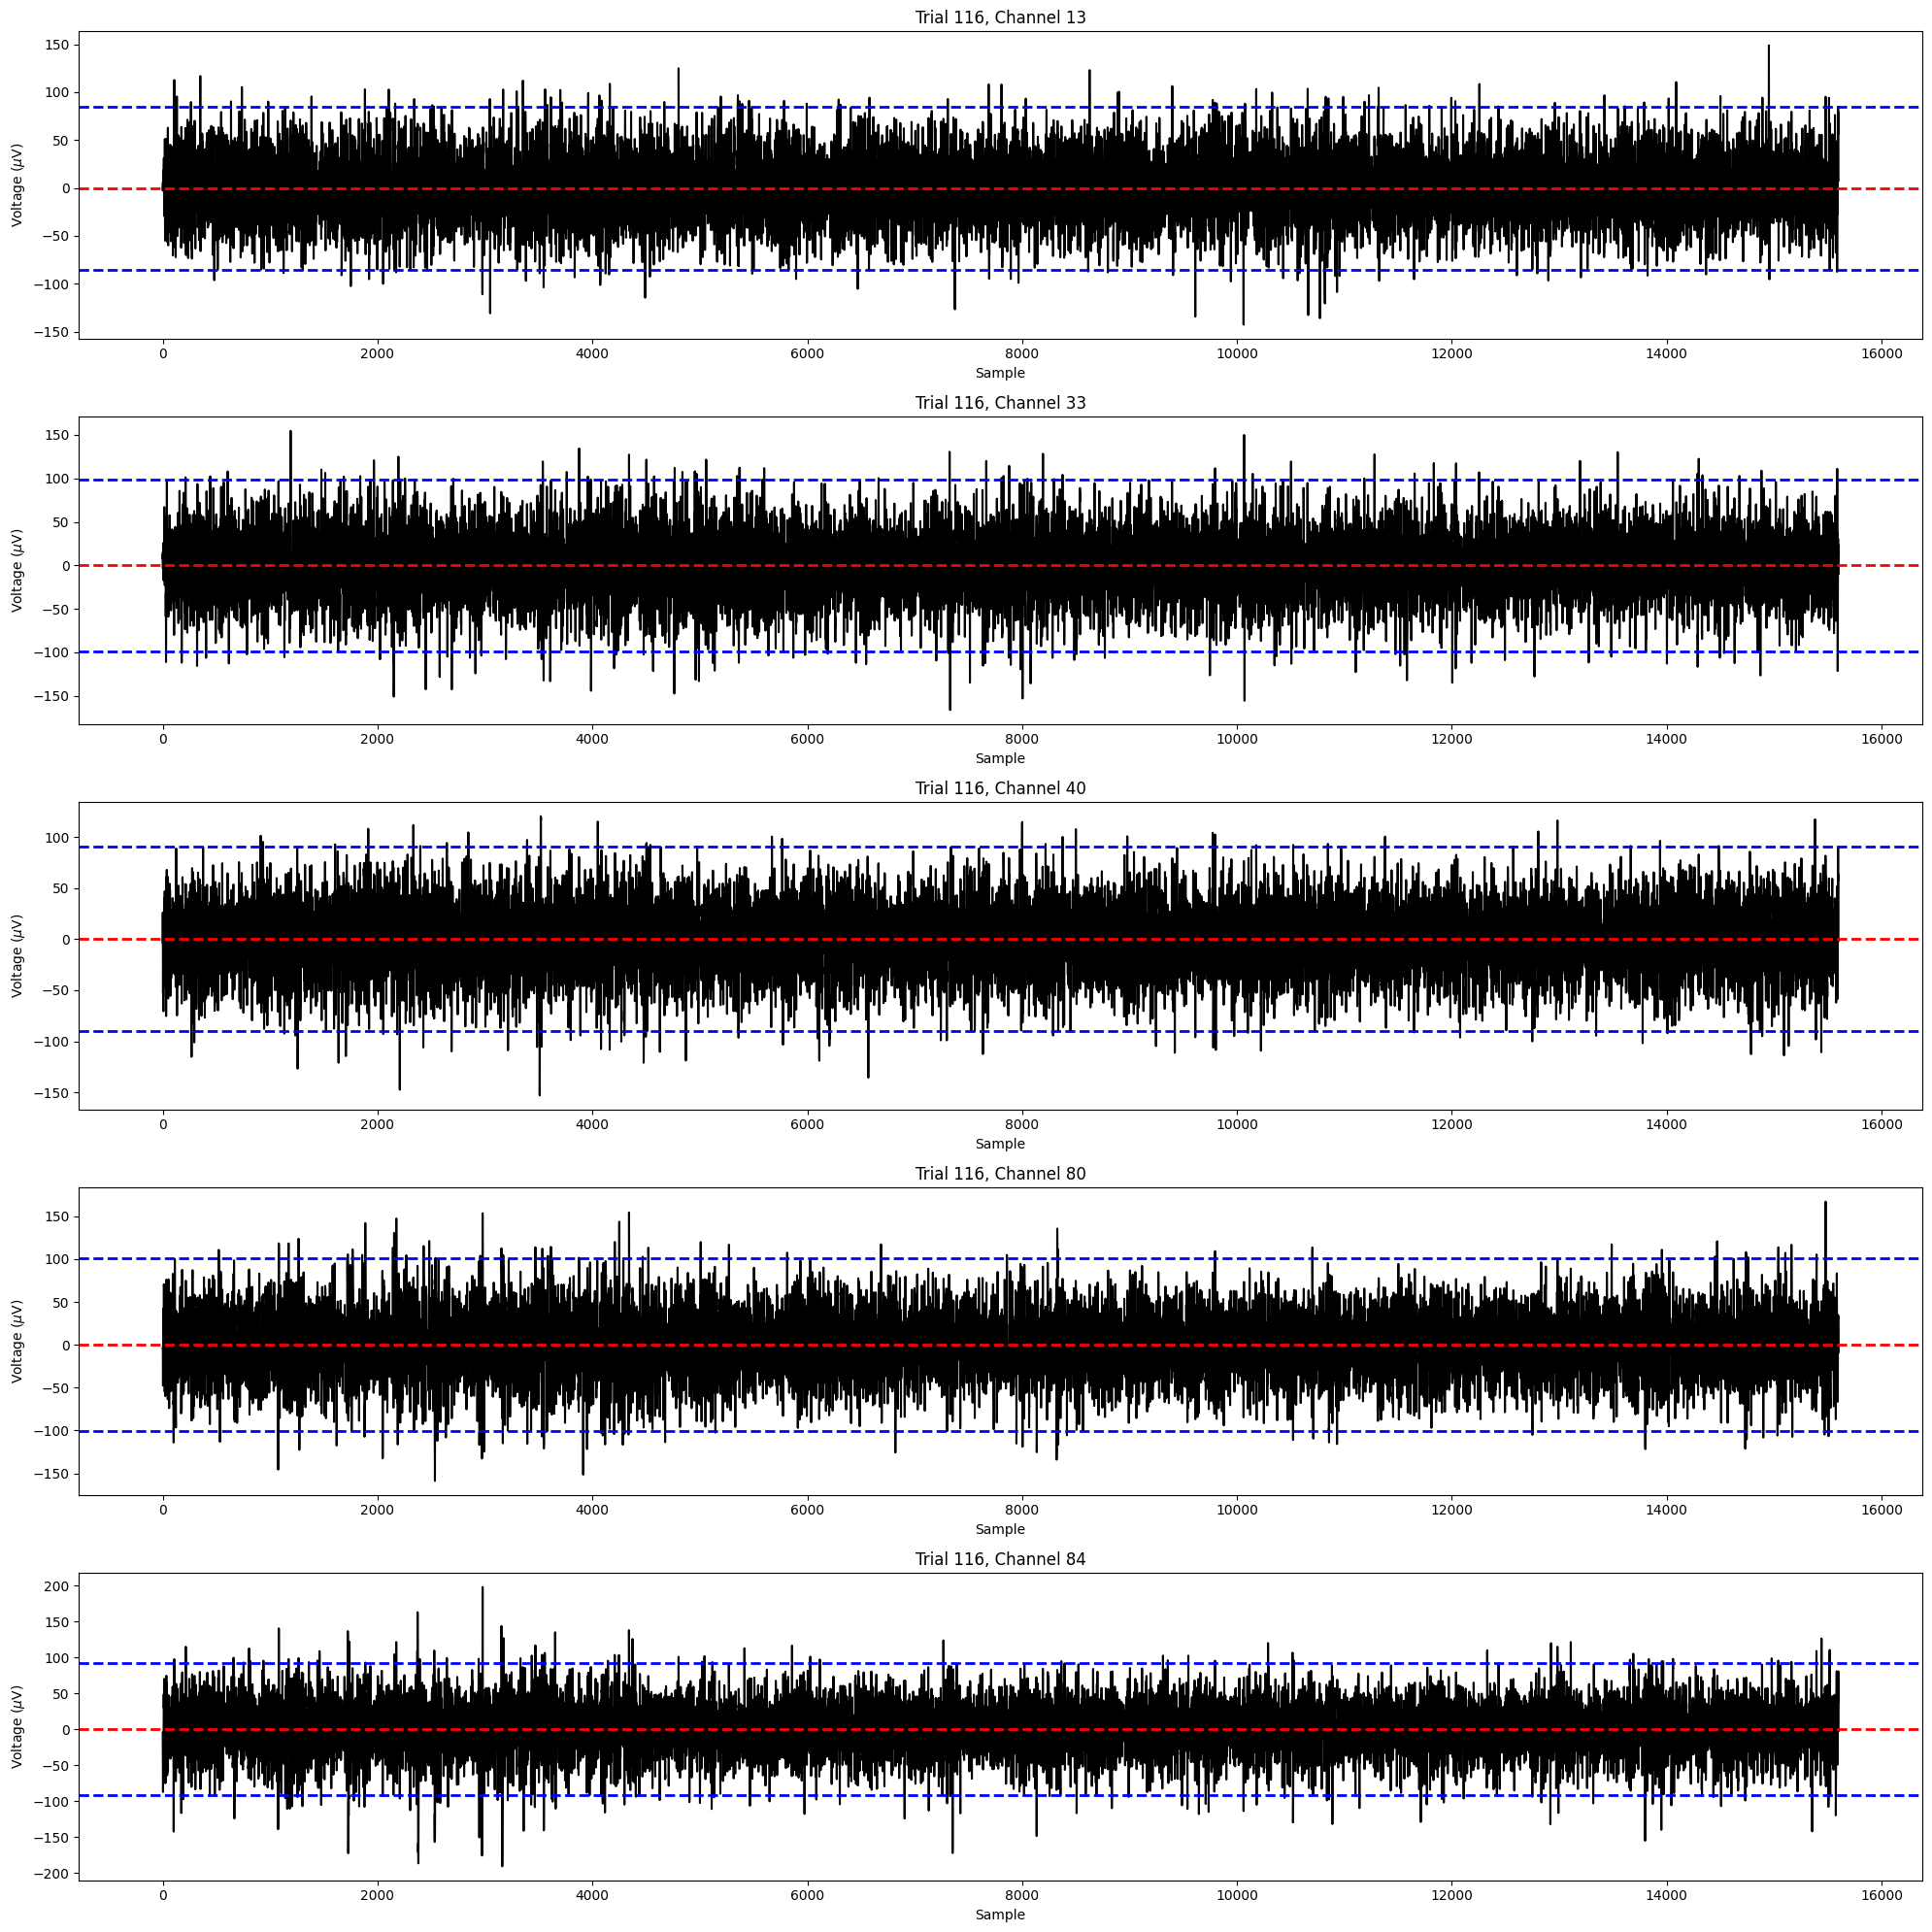

In [27]:
# plot some channels and the median
ixs = random.sample(range(150), 5)
ixs.sort()

fig, axes = plt.subplots(5, 1, figsize=(20, 20))

axes = axes.flatten()

trial_no = 50

for i, j in enumerate(ixs):
    ax = axes[i]

    x = np.arange(0, filt_data[trial_no].shape[1])
    y = filt_data[trial_no][j, :]

    ax.plot(x, y, color="black")
   
    ax.set_title(f"Trial {control_idxs[trial_no]}, Channel {j}")
    ax.set_xlabel("Sample")
    ax.set_ylabel("Voltage ($\mu$V)")

    lower, upper = get_thresh(filt_data[trial_no][j, :], medians[trial_no][j])

    ax.axhline(y=medians[trial_no][j], color='r', linestyle='--', linewidth=2)
    ax.axhline(y=lower, color='blue', linestyle='--', linewidth=2)
    ax.axhline(y=upper, color='blue', linestyle='--', linewidth=2)


plt.tight_layout()


plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds/MUA_trial{control_idxs[trial_no]}.png")

plt.show()


In [57]:
num_devs = [0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 6, 7]

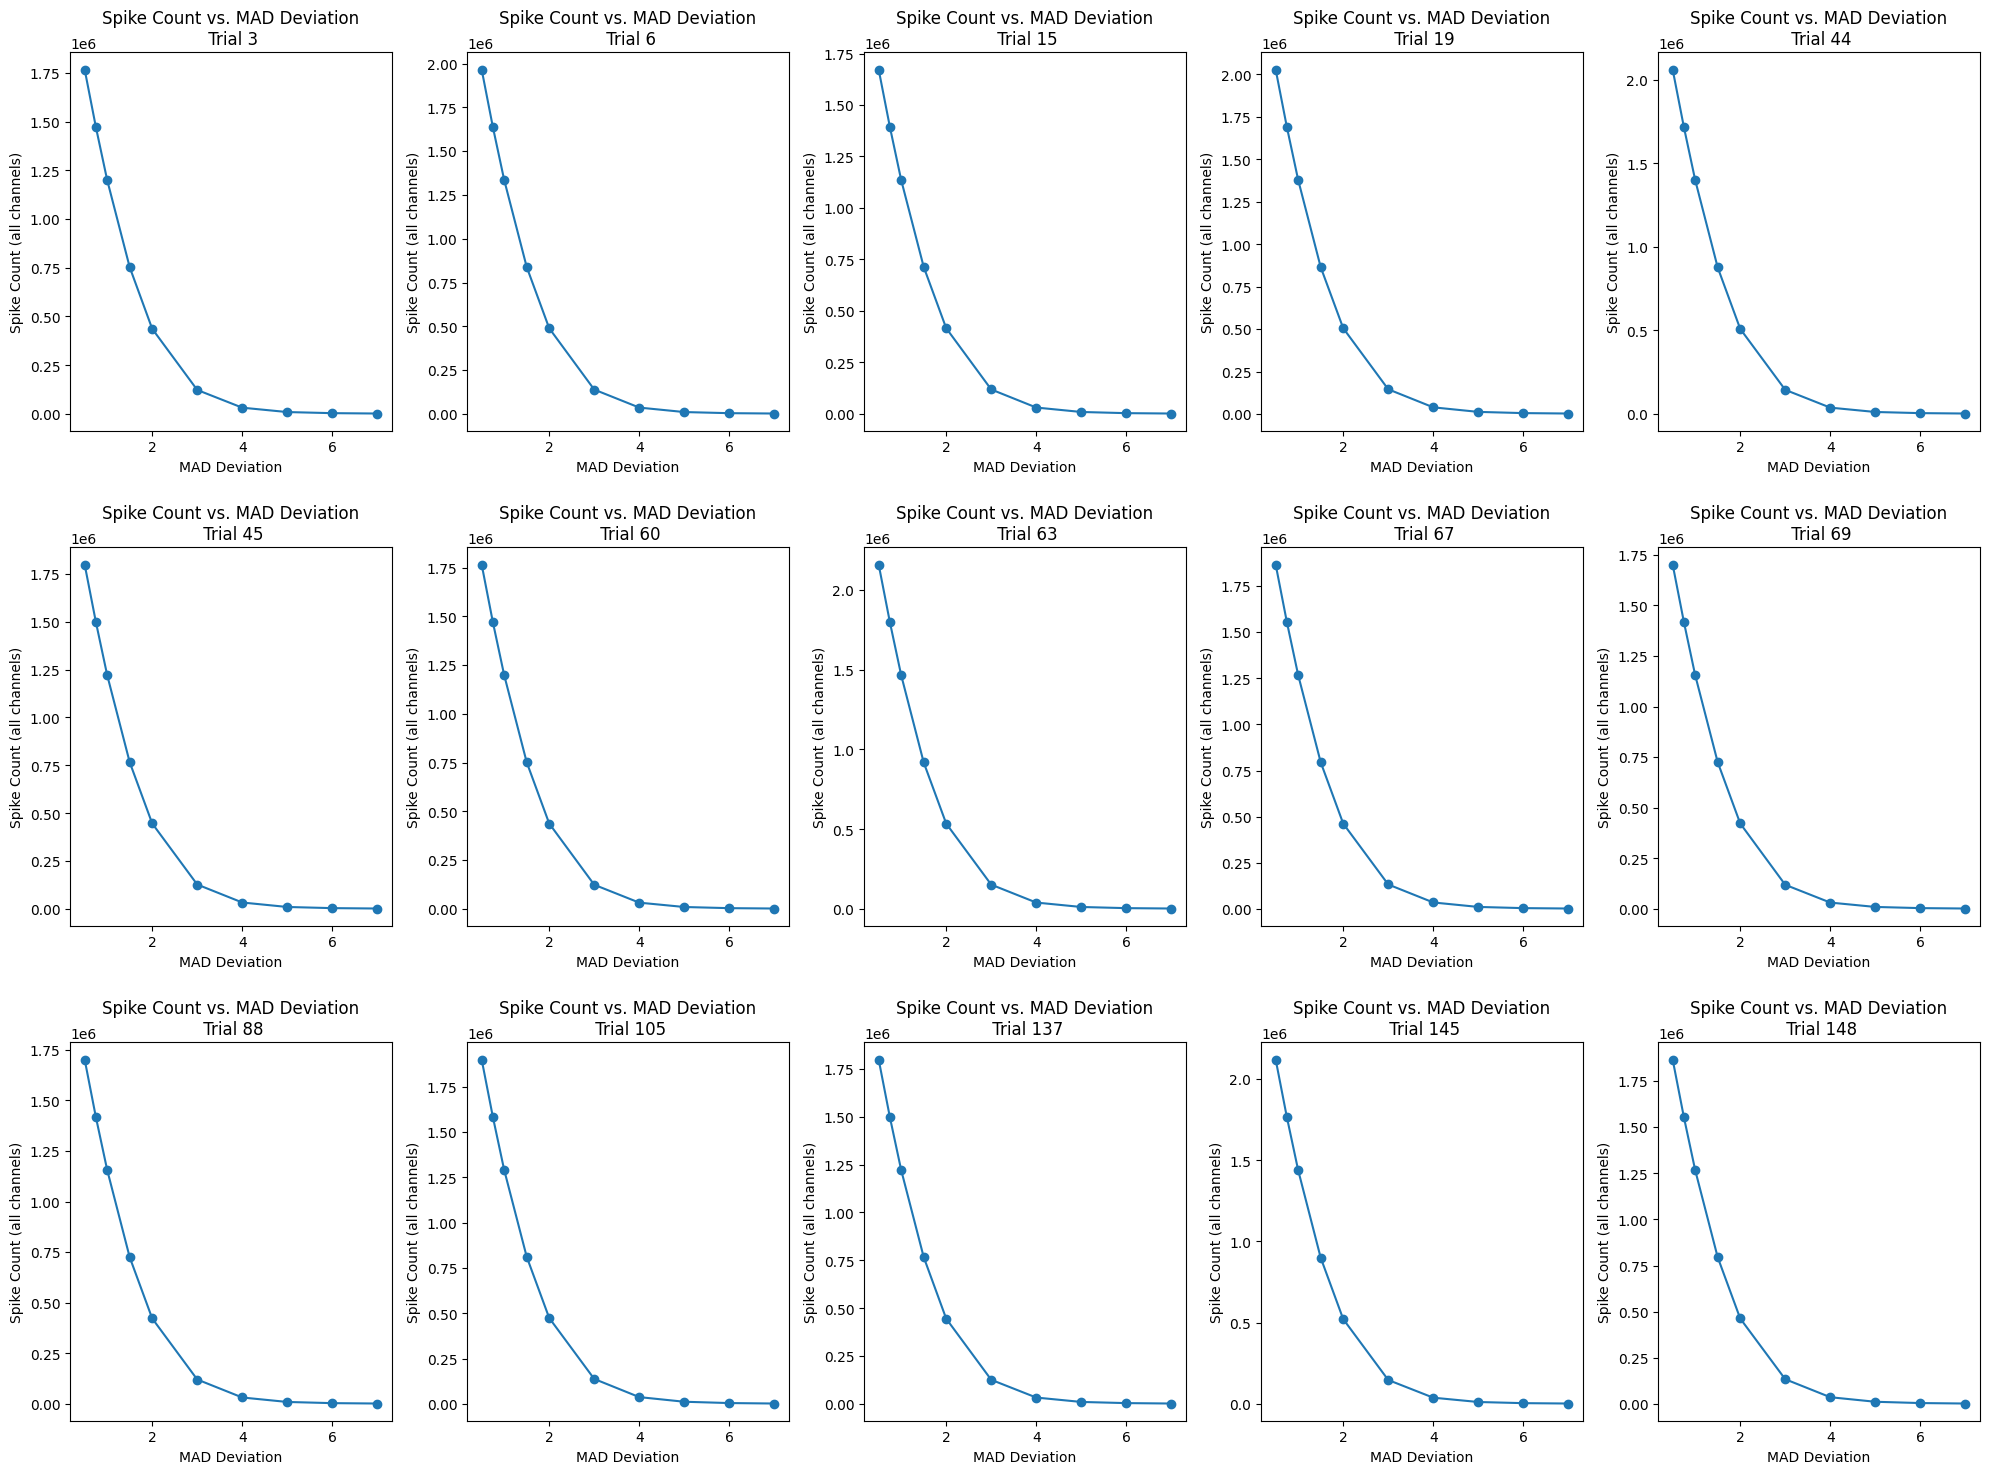

In [58]:
ixs = random.sample(range(56), 15)
ixs.sort()

fig, axes = plt.subplots(3, 5, figsize=(20, 15))

axes = axes.flatten()

for i, j in enumerate(ixs):
    ax = axes[i]
    trial_no = j
    
    c = list()
    for dev in num_devs:
        _, counts = get_spike_events(filt_data[trial_no], medians[trial_no], num_dev=dev)
       # total_count = sum(counts)
        c.append(sum(counts))
    
    ax.plot(num_devs, c, marker='o')

    ax.set_title(f"Spike Count vs. MAD Deviation\n Trial {control_idxs[trial_no]}")
    ax.set_xlabel("MAD Deviation")
    ax.set_ylabel("Spike Count (all channels)")

   # ax.set_xticks(num_devs)

plt.tight_layout()

#plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds/MAD_allchans.png")

plt.show()

In [97]:
num_devs = [0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]

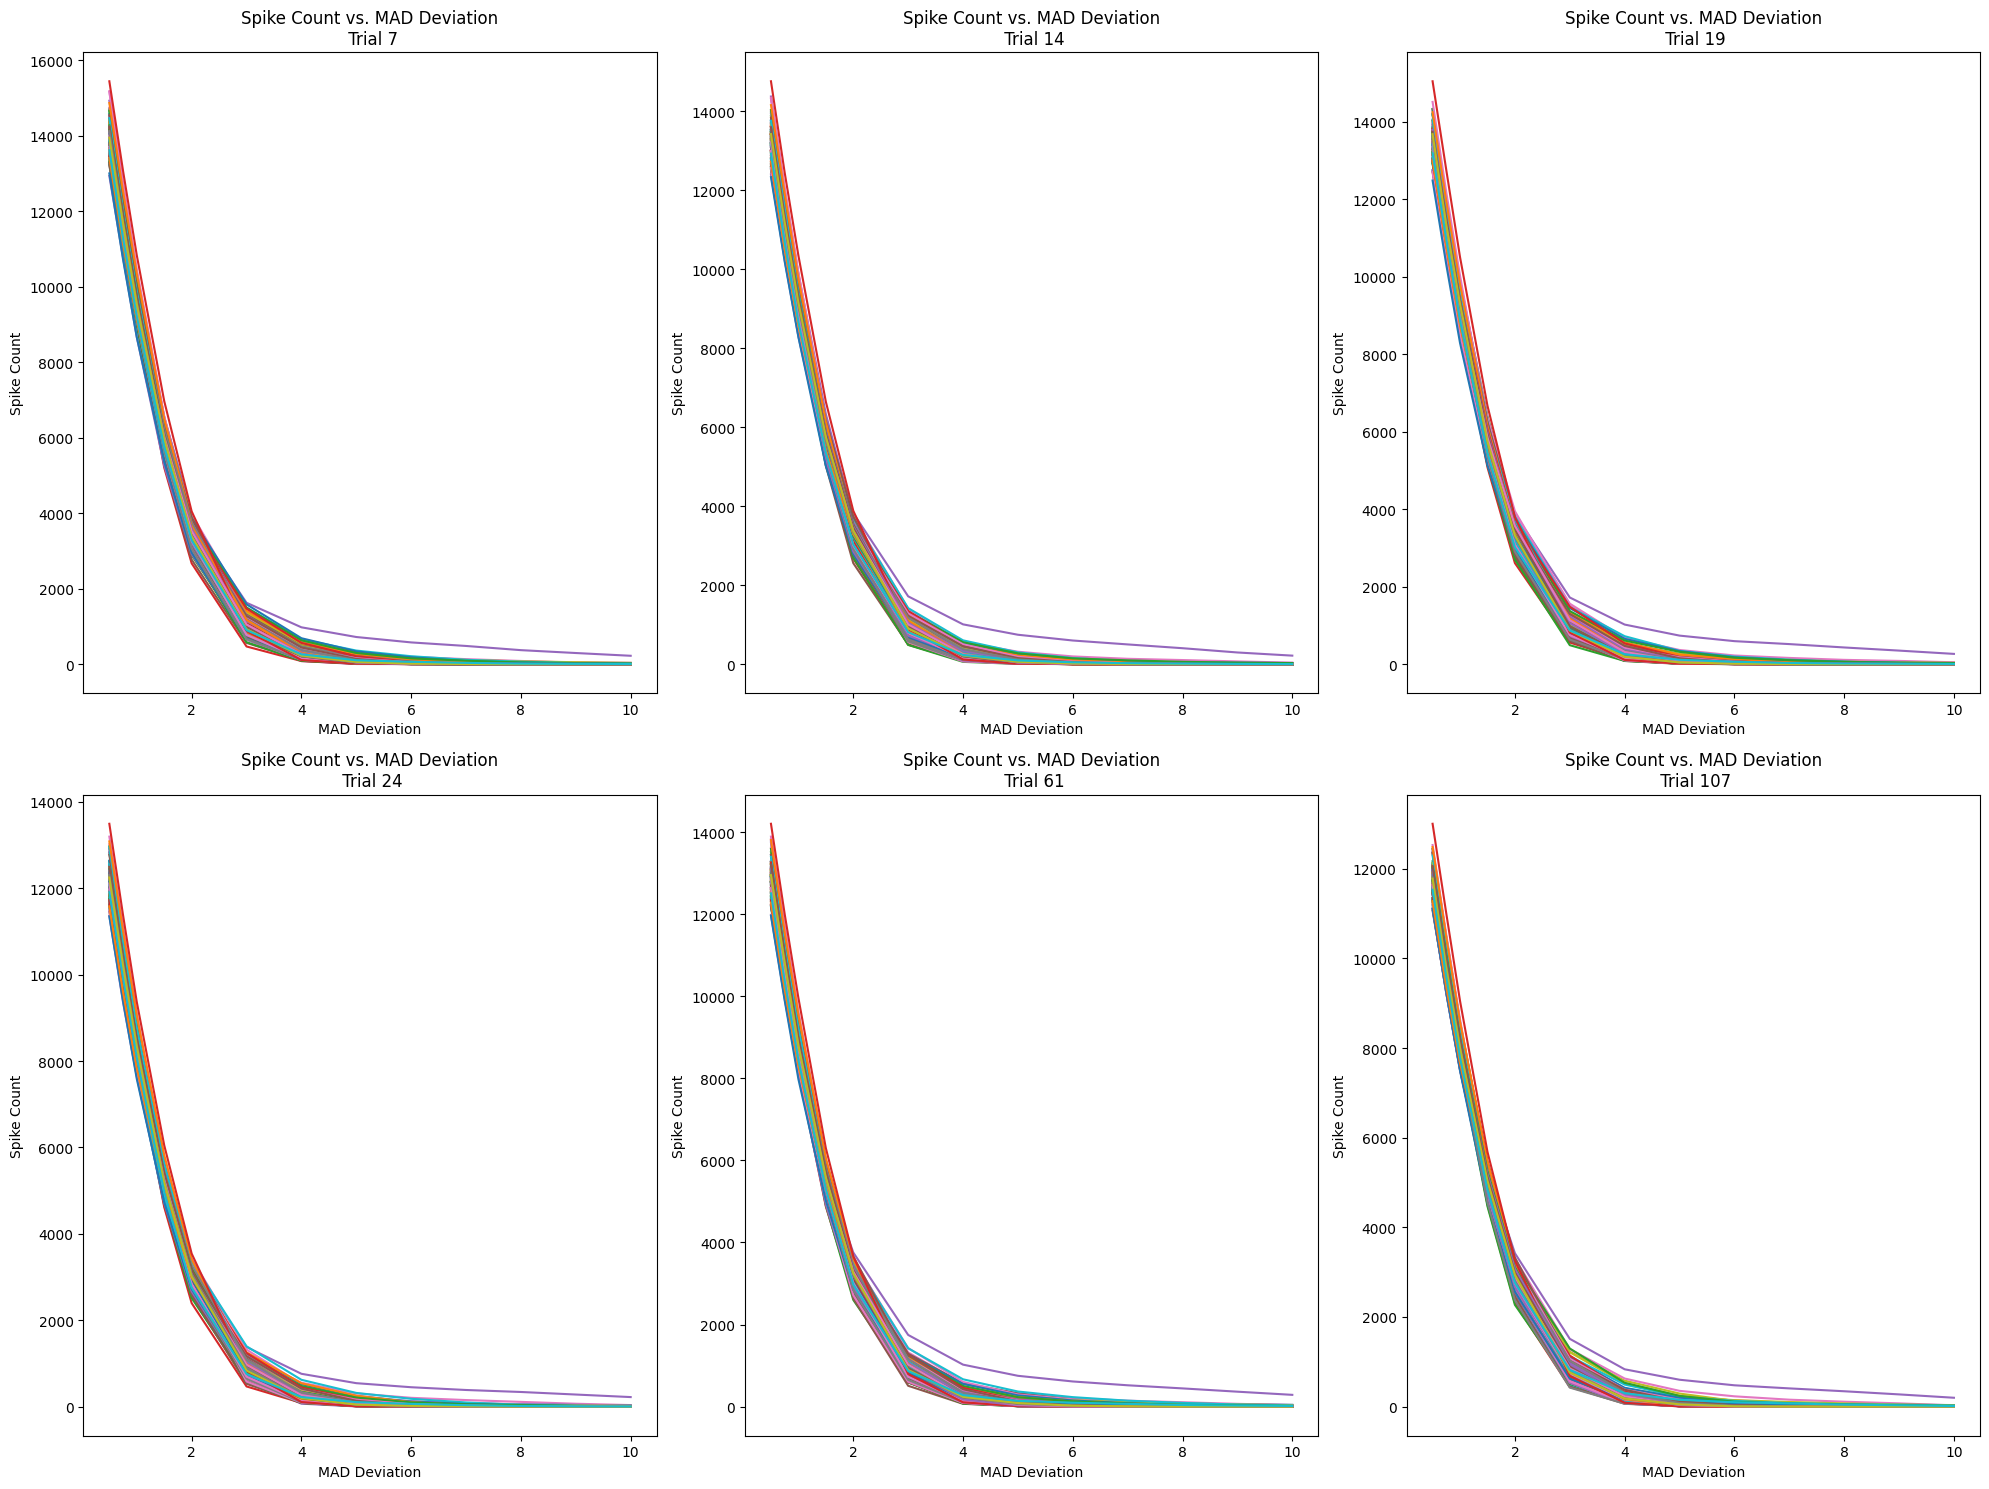

In [98]:
ixs = random.sample(range(56), 6)
ixs.sort()

fig, axes = plt.subplots(2, 3, figsize=(20, 15))

axes = axes.flatten()

max_channels = dict()

for i, j in enumerate(ixs):
    ax = axes[i]
    trial_no = j

    max_channels[trial_no] = dict()

    results = list()
    
    for dev in num_devs:
        _, counts = get_spike_events(filt_data[trial_no], medians[trial_no], num_dev=dev)
        results.append(counts)

        max_channels[trial_no][dev] = counts.index(max(counts))
       # total_count = sum(counts)

    # list of devs with 1 val per channels 
    for z in range(150):
        c = list()
        for r in results:
            c.append(r[z])
        
        ax.plot(num_devs, c)

    ax.set_title(f"Spike Count vs. MAD Deviation\n Trial {control_idxs[trial_no]}")
    ax.set_xlabel("MAD Deviation")
    ax.set_ylabel("Spike Count")

   # ax.set_xticks(num_devs)

plt.tight_layout()

#plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds/MAD.png")

plt.show()

In [99]:
# channels 143 and 54 in all of these trials seem weird

In [100]:
max_channels

{6: {0.5: 143,
  0.75: 143,
  1: 143,
  1.5: 143,
  2: 143,
  3: 54,
  4: 54,
  5: 54,
  6: 54,
  7: 54,
  8: 54,
  9: 54,
  10: 54},
 11: {0.5: 143,
  0.75: 143,
  1: 143,
  1.5: 143,
  2: 143,
  3: 54,
  4: 54,
  5: 54,
  6: 54,
  7: 54,
  8: 54,
  9: 54,
  10: 54},
 14: {0.5: 143,
  0.75: 143,
  1: 143,
  1.5: 143,
  2: 66,
  3: 54,
  4: 54,
  5: 54,
  6: 54,
  7: 54,
  8: 54,
  9: 54,
  10: 54},
 18: {0.5: 143,
  0.75: 143,
  1: 143,
  1.5: 143,
  2: 143,
  3: 119,
  4: 54,
  5: 54,
  6: 54,
  7: 54,
  8: 54,
  9: 54,
  10: 54},
 34: {0.5: 143,
  0.75: 143,
  1: 143,
  1.5: 143,
  2: 54,
  3: 54,
  4: 54,
  5: 54,
  6: 54,
  7: 54,
  8: 54,
  9: 54,
  10: 54},
 49: {0.5: 143,
  0.75: 143,
  1: 143,
  1.5: 143,
  2: 54,
  3: 54,
  4: 54,
  5: 54,
  6: 54,
  7: 54,
  8: 54,
  9: 54,
  10: 54}}

In [101]:
list(max_channels.keys())

[6, 11, 14, 18, 34, 49]

In [102]:
num_devs

[0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [103]:
import matplotlib.cm as cm
cmap = cm.get_cmap('winter', len(num_devs))
colors = [cmap(i) for i in range(len(num_devs))]

/tmp/ipykernel_12640/1721599625.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('winter', len(num_devs))


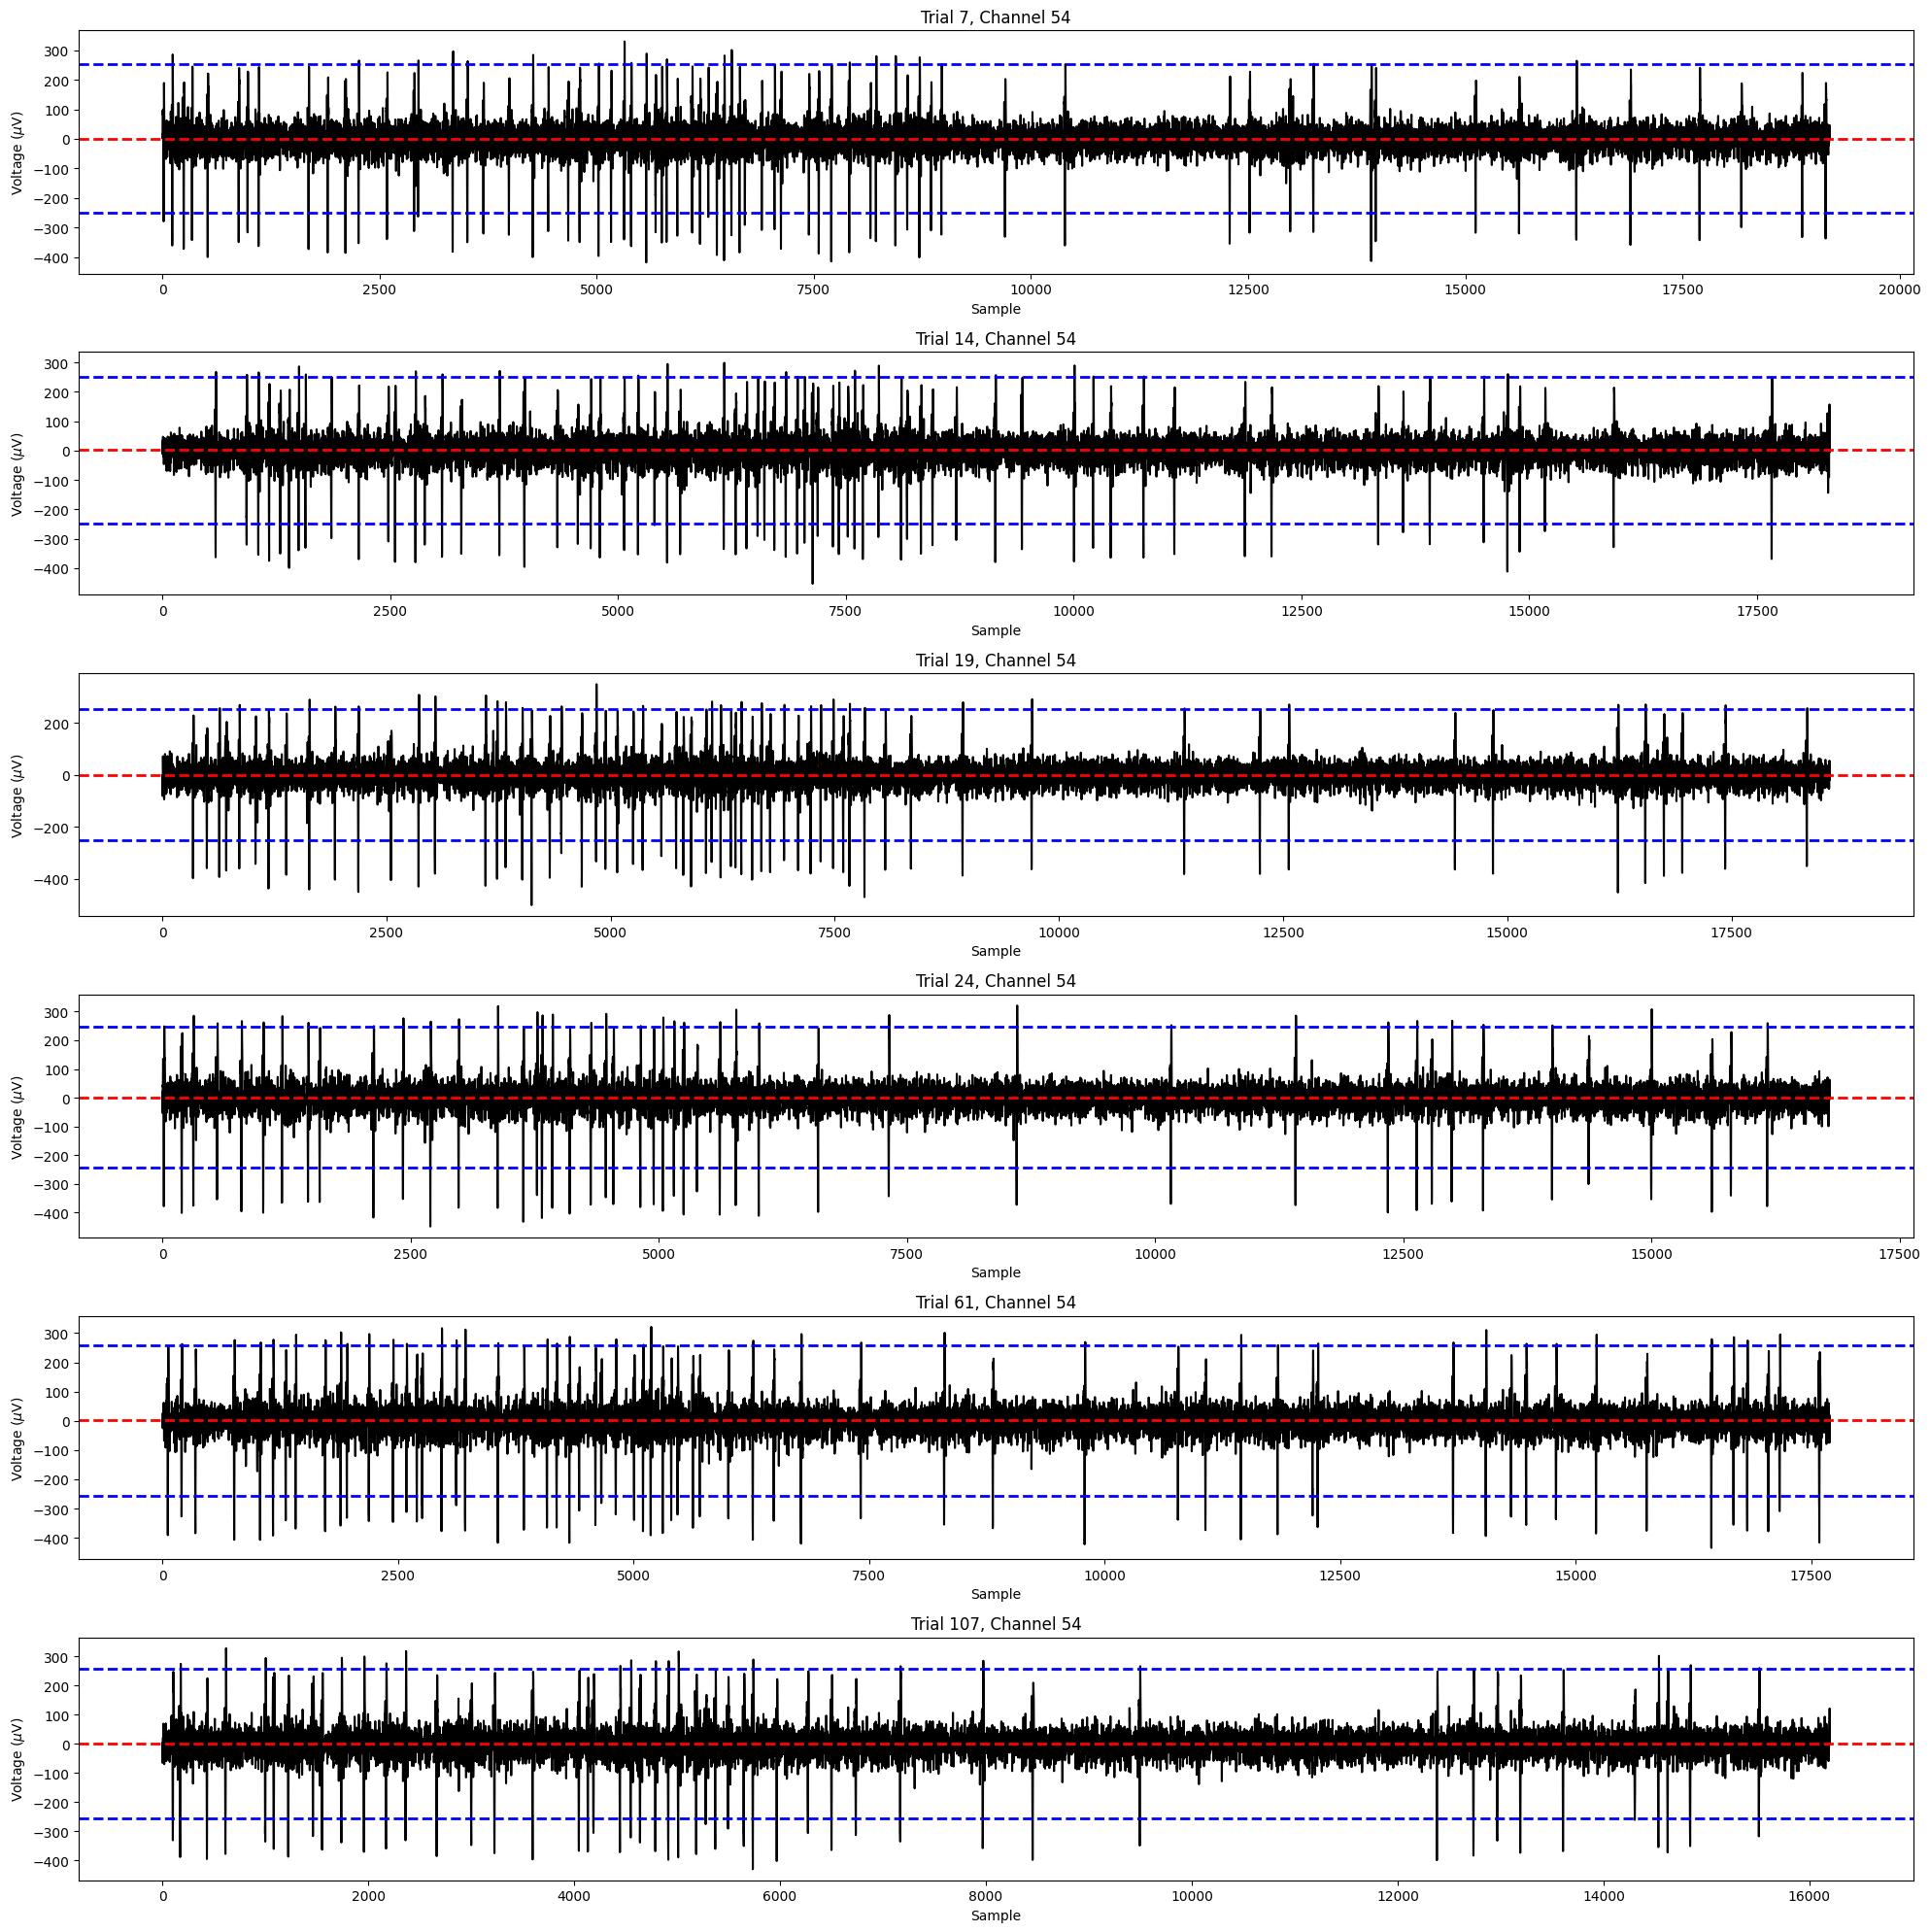

In [105]:
fig, axes = plt.subplots(6, 1, figsize=(20, 20))

axes = axes.flatten()

chan_no = 54

ixs = list(max_channels.keys())

for i, j in enumerate(ixs):
    ax = axes[i]
    trial_no = j 

    x = np.arange(0, filt_data[trial_no].shape[1])
    y = filt_data[trial_no][chan_no, :]

    ax.plot(x, y, color="black")
   
    ax.set_title(f"Trial {control_idxs[trial_no]}, Channel {chan_no}")
    ax.set_xlabel("Sample")
    ax.set_ylabel("Voltage ($\mu$V)")

    

    ax.axhline(y=medians[trial_no][chan_no], color="red", linestyle='--', linewidth=2)

    #for z, n in enumerate(num_devs):
    lower, upper = get_thresh(filt_data[trial_no][chan_no, :], medians[trial_no][chan_no], num_dev=num_devs[-1])

    ax.axhline(y=lower, color="blue", linestyle='--', linewidth=2)
    ax.axhline(y=upper, color="blue", linestyle='--', linewidth=2)


plt.tight_layout()

#plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds/MAD_chan54.png")